<H3>Global Model-Agnostic Methods</H3>
<p>Global methods describe the average behaviour of a machine learning model. They are often expressed as expected values based on distribution of data</p>
<ul>
    <li>PDP, partial dependence plot is a feature effect method</li>
    <li>the method can be used in both classification and regression problems</li>
    <li><b>PDP assumption</b> is that target feature S is not correlated to any other features in feature space. However, it's very hard to achieve. Hence it's the biggest shortage of PDP.</li>
</ul>
<p>What is partial dependence plot</p>
<ul>
    <li><p>The definition of Partial dependence plot</p>
    <img src='./assets/pics/s81_pdp_def.jpg' alt='Partial dependece plot' width='400'></li>
    <li><p>Empirical calcuation of pdp</p>
    <img src='./assets/pics/s82_pdp_calc.jpg' alt='Calculation' width='200'></li>
</ul>

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lib.process_data import process_bike


Bad key "text.kerning_factor" on line 4 in
e:\Projects\Envs\Repo\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# set up plotting theme and configurations
#plt.style.available # to find all the style available to matplotlib
plt.style.use('ggplot')
colour_collection = {'orange':"#ff9124", 'blue':"#2492ff"}

<h3>Loading bike data and regression model</h3>

In [3]:
# loading bike data
cols_df, bike_df = process_bike("./data/bike.csv")
feature_cols = cols_df.loc[cols_df.input.isin(['num']),'cols'].to_list()
resp = 'cnt'
X = bike_df[feature_cols].to_numpy()
y = bike_df[resp].to_numpy()

convert yr to string


In [4]:
# loading bike model and fetching predicted value along with bike_df
lasso_model = pickle.load(open("./model/bike_lasso.sav",'rb'))
gradient_tree_model = pickle.load(open("./model/bike_boost_tree.sav",'rb'))
outcome_df = pd.DataFrame(data=np.hstack([X
    , y.reshape(-1,1)
    , lasso_model.predict(X).reshape(-1,1)
    , gradient_tree_model.predict(X).reshape(-1,1)
]), columns = feature_cols + ['actual','lasso_pred', 'gbt_pred'])
outcome_df.head(5)

,temp,hum,windspeed,days_since_2011,season_encoded,yr_encoded,mnth_encoded,holiday_encoded,weekday_encoded,workingday_encoded,weathersit_encoded,actual,lasso_pred,gbt_pred
0,8.175849,80.5833,10.749882,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,985.0,1302.340894,1205.215691
1,9.083466,69.6087,16.652113,1.0,3.0,0.0,0.0,0.0,6.0,0.0,0.0,801.0,1346.367326,1527.731160
2,1.229108,43.7273,16.636703,2.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1349.0,1203.845992,1266.543447
3,1.400000,59.0435,10.739832,3.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,1562.0,1172.281448,1452.411320
4,2.666979,43.6957,12.522300,4.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1600.0,1607.003516,1645.921447


In [5]:
# loading the encode map
encode_map = {'season':['SPRING','SUMMER','FALL','WINTER']
        , 'yr':['2011','2012']
        , 'mnth':['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
        , 'holiday':['NO HOLIDAY','HOLIDAY']
        , 'weekday':['MON','TUE','WED','THU','FRI','SAT','SUN']
        , 'workingday':['NO WORKING DAY','WORKING DAY']
        , 'weathersit':['MISTY','GOOD','RAIN/SNOW/STORM']
    }

In [6]:
# lasso's coef table
feature_df = pd.DataFrame(np.hstack([
    np.array(feature_cols).reshape(-1,1)\
    , lasso_model.coef_.reshape(-1,1)])\
    , columns=['features','coef'])
feature_df

,features,coef
0,temp,107.23115878096603
1,hum,-25.896402703428233
2,windspeed,-57.9913661447737
3,days_since_2011,4.924194584100834
4,season_encoded,-281.0821979534998
5,yr_encoded,197.73937386253644
6,mnth_encoded,-44.529472625157084
7,holiday_encoded,-547.2552873132154
8,weekday_encoded,-0.14680794847795178
9,workingday_encoded,107.81567428731715


<h3>Implement Partial Dependency Plot</h3>
<ol>
    <li>based on its definition. If feature S is the feature of interest, then we average the rest of the feature space to create the function between S and prediction.</li>
    <li>We also will implement a dpBox version to validate our calculation</li>
</ol>
<p><b><u>NOTE: </u></b>We found that the result difference between our own PDP plot function and pdpBox plot. It's worthy of further investigation. However, my belief is that pdpBox plotting averaged contribution to the total prediction from the feature. Our PDP plot displays the average prediction based on feature value.</p>
<p>Reference</p>
<ul>
<li><a href="https://towardsdatascience.com/pitfalls-to-avoid-while-interpreting-machine-learning-pdp-ice-case-c63eeb596590">Avoid PDP pitfalls</a></li>
<li><a href="https://www.kaggle.com/code/satyads/how-not-to-interpret-a-partial-dependence-plot?scriptVersionId=46333836">Kaggle tutorial on PDP</a></li>
<li><a href="https://scikit-learn.org/stable/modules/partial_dependence.html">Scikit-learn Partial Dependence Display</a></li>
</ul>

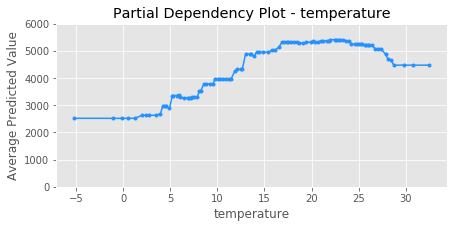

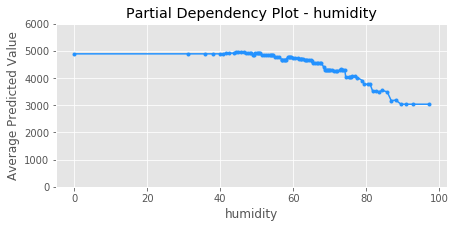

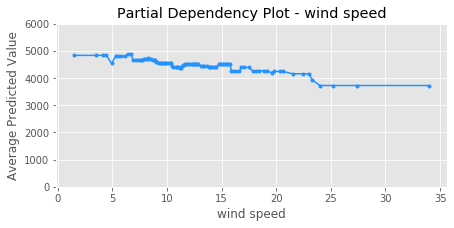

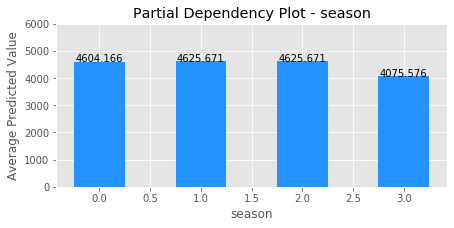

In [7]:
from lib.ml_helper import *
# plotting variables for bike data
blueprint = {'temperature':0, 'humidity':1, 'wind speed':2, 'season':4}
for k,v in blueprint.items():
    g=plot_pdp(estimator = gradient_tree_model, estimator_cd = 'regression', X = X, var_idx = v, var_name = k, ylim=(0,6000), n_split=100)
    g.show()

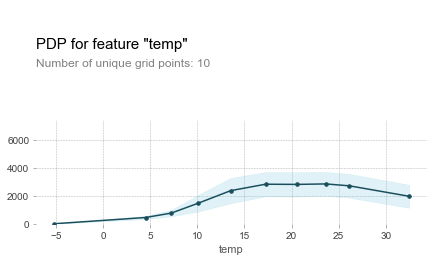

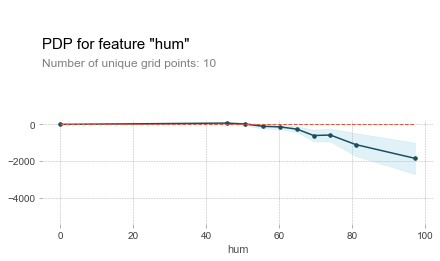

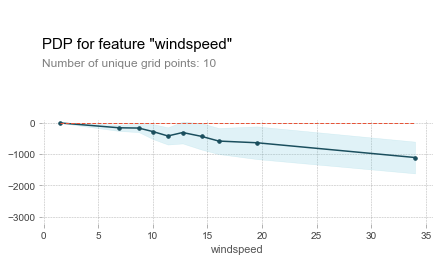

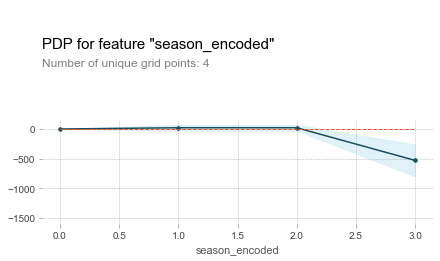

In [9]:
from pdpbox.pdp import pdp_plot, pdp_isolate
for col in ['temp','hum','windspeed','season_encoded']:
    pdp_isolated = pdp_isolate(\
        model = gradient_tree_model\
        , dataset = bike_df\
        , model_features = feature_cols
        , feature = col)
    fig, axes = pdp_plot(pdp_isolate_out=pdp_isolated, feature_name = col, figsize=(7,4))